In [1]:
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
! pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 27.9 MB/s eta 0:00:00


# Imports

In [4]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
from torchaudio.datasets import SPEECHCOMMANDS
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from melbanks import LogMelFilterBanks

pl.seed_everything(42)
os.makedirs("./data", exist_ok=True)

INFO:lightning_fabric.utilities.seed:Seed set to 42


# Dataset class

In [14]:
# Модифицированный класс BinarySpeechCommands с фиксированной длиной аудио
class BinarySpeechCommands(Dataset):
    def __init__(self, root_dir="./data", subset="training", n_mels=80):
        print(f"Загрузка датасета {subset} с n_mels={n_mels}...")
        self.dataset = SPEECHCOMMANDS(root=root_dir, subset=subset, download=True)
        print(f"Датасет {subset} загружен, фильтрация YES/NO...")

        self.n_mels = n_mels
        self.mel_transform = LogMelFilterBanks(n_mels=n_mels)

        # Filter only "yes" and "no" samples
        self.indices = []
        for i in range(len(self.dataset)):
            waveform, sample_rate, label, *_ = self.dataset[i]
            if label.lower() in ["yes", "no"]:
                self.indices.append(i)

        print(f"Найдено {len(self.indices)} примеров YES/NO в наборе {subset}")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        waveform, sample_rate, label, *_ = self.dataset[original_idx]

        # Apply LogMelFilterBanks
        mel_spec = self.mel_transform(waveform)

        # Convert label to binary: 1 for "yes", 0 for "no"
        target = 1 if label.lower() == "yes" else 0

        return mel_spec, target

# Пользовательская функция коллации для батчей разной длины
def collate_fn(batch):
    # Отделяем спектрограммы от классов
    spectrograms = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])

    # Находим максимальную длину спектрограммы в батче
    max_length = max(spec.shape[-1] for spec in spectrograms)

    # Создаем паддинг для выравнивания длин
    padded_specs = []
    for spec in spectrograms:
        current_length = spec.shape[-1]
        if current_length < max_length:
            # Паддинг нулями до максимальной длины
            padding = torch.zeros(spec.shape[0], spec.shape[1], max_length - current_length,
                                  device=spec.device)
            padded_spec = torch.cat([spec, padding], dim=-1)
            padded_specs.append(padded_spec)
        else:
            padded_specs.append(spec)

    # Стекаем паддинговые спектрограммы в один тензор
    padded_specs = torch.stack(padded_specs)

    return padded_specs, labels

# CNN Model

In [16]:
# Модифицированный класс BinarySpeechCommands с фиксированной длиной аудио
class BinarySpeechCommands(Dataset):
    def __init__(self, root_dir="./data", subset="training", n_mels=80):
        print(f"Загрузка датасета {subset} с n_mels={n_mels}...")
        self.dataset = SPEECHCOMMANDS(root=root_dir, subset=subset, download=True)
        print(f"Датасет {subset} загружен, фильтрация YES/NO...")

        self.n_mels = n_mels
        self.mel_transform = LogMelFilterBanks(n_mels=n_mels)

        # Filter only "yes" and "no" samples
        self.indices = []
        for i in range(len(self.dataset)):
            waveform, sample_rate, label, *_ = self.dataset[i]
            if label.lower() in ["yes", "no"]:
                self.indices.append(i)

        print(f"Найдено {len(self.indices)} примеров YES/NO в наборе {subset}")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        waveform, sample_rate, label, *_ = self.dataset[original_idx]

        # Apply LogMelFilterBanks
        mel_spec = self.mel_transform(waveform)

        # Convert label to binary: 1 for "yes", 0 for "no"
        target = 1 if label.lower() == "yes" else 0

        return mel_spec, target

# Пользовательская функция коллации для батчей разной длины
def collate_fn(batch):
    # Отделяем спектрограммы от классов
    spectrograms = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])

    # Находим максимальную длину спектрограммы в батче
    max_length = max(spec.shape[-1] for spec in spectrograms)

    # Создаем паддинг для выравнивания длин
    padded_specs = []
    for spec in spectrograms:
        current_length = spec.shape[-1]
        if current_length < max_length:
            # Паддинг нулями до максимальной длины
            padding = torch.zeros(spec.shape[0], spec.shape[1], max_length - current_length,
                                  device=spec.device)
            padded_spec = torch.cat([spec, padding], dim=-1)
            padded_specs.append(padded_spec)
        else:
            padded_specs.append(spec)

    # Стекаем паддинговые спектрограммы в один тензор
    padded_specs = torch.stack(padded_specs)

    return padded_specs, labels

    # Обновленная функция для запуска экспериментов с n_mels
def run_n_mels_experiment(n_mels_list=[20, 40, 80], batch_size=32, epochs=5):
    results = {}

    for n_mels in n_mels_list:
        print(f"\nОбучение модели с n_mels={n_mels}")

        # Подготовка датасетов
        train_dataset = BinarySpeechCommands(subset="training", n_mels=n_mels)
        val_dataset = BinarySpeechCommands(subset="validation", n_mels=n_mels)
        test_dataset = BinarySpeechCommands(subset="testing", n_mels=n_mels)

        # Создание загрузчиков данных с пользовательской функцией коллации
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                 num_workers=0, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size,
                               num_workers=0, collate_fn=collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=batch_size,
                                num_workers=0, collate_fn=collate_fn)

        # Инициализация модели
        model = SpeechCNN(n_mels=n_mels)

        # Настройка тренера
        trainer = pl.Trainer(
            max_epochs=epochs,
            logger=True,
            callbacks=[
                ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1),
                EarlyStopping(monitor='val_acc', patience=3, mode='max')
            ]
        )

        # Обучение и тестирование
        trainer.fit(model, train_loader, val_loader)
        trainer.test(model, test_loader)

        # Сохранение результатов
        results[n_mels] = {
            'train_losses': model.train_losses,
            'val_accuracies': model.val_accuracies,
            'test_accuracy': model.test_accuracy,
            'epoch_times': model.epoch_times,
            'params_count': model.count_parameters(),
            'flops': model.calculate_flops()
        }

        print(f"n_mels={n_mels}: Test Accuracy={model.test_accuracy:.4f}")

    return results

# Обновленная функция для экспериментов с groups
def run_groups_experiment(n_mels=80, groups_list=[1, 2, 4, 8], batch_size=32, epochs=5):
    results = {}

    for groups in groups_list:
        print(f"\nОбучение модели с groups={groups}")

        # Подготовка датасетов
        train_dataset = BinarySpeechCommands(subset="training", n_mels=n_mels)
        val_dataset = BinarySpeechCommands(subset="validation", n_mels=n_mels)
        test_dataset = BinarySpeechCommands(subset="testing", n_mels=n_mels)

        # Создание загрузчиков данных с пользовательской функцией коллации
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                 num_workers=0, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size,
                               num_workers=0, collate_fn=collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=batch_size,
                                num_workers=0, collate_fn=collate_fn)

        # Инициализация модели
        model = SpeechCNN(n_mels=n_mels, groups=groups)

        # Настройка тренера
        trainer = pl.Trainer(
            max_epochs=epochs,
            logger=True,
            callbacks=[
                ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1),
                EarlyStopping(monitor='val_acc', patience=3, mode='max')
            ]
        )

        # Обучение и тестирование
        trainer.fit(model, train_loader, val_loader)
        trainer.test(model, test_loader)

        # Сохранение результатов
        results[groups] = {
            'train_losses': model.train_losses,
            'val_accuracies': model.val_accuracies,
            'test_accuracy': model.test_accuracy,
            'epoch_times': model.epoch_times,
            'params_count': model.count_parameters(),
            'flops': model.calculate_flops()
        }

        print(f"groups={groups}: Test Accuracy={model.test_accuracy:.4f}")

    return results

# Experiments

## n_mels

In [7]:
# Функция для создания и обучения модели с одним набором параметров
def train_single_model(n_mels, groups=1, batch_size=32, epochs=5, num_workers=2):
    print(f"\nОбучение модели с n_mels={n_mels}, groups={groups}")

    # Подготовка датасетов
    train_dataset = BinarySpeechCommands(subset="training", n_mels=n_mels)
    val_dataset = BinarySpeechCommands(subset="validation", n_mels=n_mels)
    test_dataset = BinarySpeechCommands(subset="testing", n_mels=n_mels)

    # Создание загрузчиков данных
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

    # Инициализация модели
    model = SpeechCNN(n_mels=n_mels, groups=groups)

    # Настройка логгера и колбэков
    logger = TensorBoardLogger("lightning_logs", name=f"n_mels_{n_mels}_groups_{groups}")

    checkpoint_callback = ModelCheckpoint(
        monitor='val_acc',
        mode='max',
        save_top_k=1,
        filename=f'model_n_mels_{n_mels}_groups_{groups}_{{epoch:02d}}_{{val_acc:.4f}}'
    )

    early_stop_callback = EarlyStopping(
        monitor='val_acc',
        patience=3,
        mode='max'
    )

    # Инициализация тренера
    trainer = pl.Trainer(
        max_epochs=epochs,
        logger=logger,
        callbacks=[checkpoint_callback, early_stop_callback],
        log_every_n_steps=10
    )

    # Обучение модели
    trainer.fit(model, train_loader, val_loader)

    # Тестирование модели
    trainer.test(model, test_loader)

    # Расчет дополнительных метрик
    params_count = model.count_parameters()
    flops = model.calculate_flops()

    # Сохранение результатов
    results = {
        'train_losses': model.train_losses,
        'val_accuracies': model.val_accuracies,
        'test_accuracy': model.test_accuracy,
        'epoch_times': model.epoch_times,
        'params_count': params_count,
        'flops': flops
    }

    print(f"n_mels={n_mels}, groups={groups}:")
    print(f"  Test Accuracy: {model.test_accuracy:.4f}")
    print(f"  Parameters: {params_count}")
    print(f"  FLOPs: {flops}")
    print(f"  Avg Epoch Time: {np.mean(model.epoch_times):.2f} сек")

    return results, model

# Функция для экспериментов с разными значениями n_mels
def experiment_with_n_mels(n_mels_list=[20, 40, 80], batch_size=32, epochs=5):
    results = {}

    for n_mels in n_mels_list:
        # Обучаем модель с текущим значением n_mels
        result, _ = train_single_model(n_mels=n_mels, groups=1, batch_size=batch_size, epochs=epochs)
        results[n_mels] = result

    return results

# Тестовый запуск с малым количеством эпох
if False:  # Измените на True для запуска теста
    test_results = experiment_with_n_mels(n_mels_list=[20], epochs=1)
    print("Тестовый запуск завершен!")

## groups

In [8]:
# Функция для экспериментов с разными значениями groups
def experiment_with_groups(n_mels=80, groups_list=[1, 2, 4, 8], batch_size=32, epochs=5):
    results = {}

    for groups in groups_list:
        # Обучаем модель с текущим значением groups
        result, _ = train_single_model(n_mels=n_mels, groups=groups, batch_size=batch_size, epochs=epochs)
        results[groups] = result

    return results

# Тестовый запуск функции для экспериментов с groups
if False:  # Измените на True для запуска теста
    test_results = experiment_with_groups(groups_list=[1], epochs=1)
    print("Тестовый запуск с groups завершен!")

# Results

In [11]:
# Function to plot results
def plot_results(n_mels_results, groups_results):
    # Plot training loss vs n_mels
    plt.figure(figsize=(12, 8))
    for n_mels, data in n_mels_results.items():
        plt.plot(data['train_losses'], label=f'n_mels={n_mels}')
    plt.title('Training Loss vs Epochs for Different n_mels')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('train_loss_vs_n_mels.png')
    plt.show()

    # Plot test accuracy vs n_mels
    plt.figure(figsize=(10, 6))
    n_mels_list = list(n_mels_results.keys())
    test_accuracies = [data['test_accuracy'] for data in n_mels_results.values()]
    plt.bar(n_mels_list, test_accuracies)
    plt.title('Test Accuracy vs n_mels')
    plt.xlabel('n_mels')
    plt.ylabel('Test Accuracy')
    for i, v in enumerate(test_accuracies):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
    plt.grid(True, axis='y')
    plt.savefig('test_accuracy_vs_n_mels.png')
    plt.show()

    # Plot epoch training time vs groups
    plt.figure(figsize=(10, 6))
    groups_list = list(groups_results.keys())
    avg_epoch_times = [np.mean(data['epoch_times']) for data in groups_results.values()]
    plt.plot(groups_list, avg_epoch_times, marker='o')
    plt.title('Average Epoch Training Time vs Groups')
    plt.xlabel('Groups')
    plt.ylabel('Time (seconds)')
    plt.grid(True)
    plt.savefig('training_time_vs_groups.png')
    plt.show()

    # Plot parameters count and FLOPs vs groups
    fig, ax1 = plt.subplots(figsize=(10, 6))
    params_counts = [data['params_count'] for data in groups_results.values()]
    flops_counts = [data['flops'] for data in groups_results.values()]

    ax1.set_xlabel('Groups')
    ax1.set_ylabel('Parameters Count', color='tab:blue')
    ax1.plot(groups_list, params_counts, marker='o', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('FLOPs', color='tab:red')
    ax2.plot(groups_list, flops_counts, marker='s', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Parameters Count and FLOPs vs Groups')
    plt.grid(True)
    plt.savefig('params_flops_vs_groups.png')
    plt.show()

    # Plot test accuracy vs groups
    plt.figure(figsize=(10, 6))
    test_accuracies = [data['test_accuracy'] for data in groups_results.values()]
    plt.bar(groups_list, test_accuracies)
    plt.title('Test Accuracy vs Groups')
    plt.xlabel('Groups')
    plt.ylabel('Test Accuracy')
    for i, v in enumerate(test_accuracies):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
    plt.grid(True, axis='y')
    plt.savefig('test_accuracy_vs_groups.png')
    plt.show()

# Experiments

In [12]:
# Запуск экспериментов с n_mels
def run_n_mels_experiment(n_mels_list=[20, 40, 80], batch_size=32, epochs=5):
    results = {}

    for n_mels in n_mels_list:
        print(f"\nОбучение модели с n_mels={n_mels}")

        # Подготовка датасетов
        train_dataset = BinarySpeechCommands(subset="training", n_mels=n_mels)
        val_dataset = BinarySpeechCommands(subset="validation", n_mels=n_mels)
        test_dataset = BinarySpeechCommands(subset="testing", n_mels=n_mels)

        # Создание загрузчиков данных
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

        # Инициализация модели
        model = SpeechCNN(n_mels=n_mels)

        # Настройка тренера
        trainer = pl.Trainer(
            max_epochs=epochs,
            logger=True,
            callbacks=[
                ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1),
                EarlyStopping(monitor='val_acc', patience=3, mode='max')
            ]
        )

        # Обучение и тестирование
        trainer.fit(model, train_loader, val_loader)
        trainer.test(model, test_loader)

        # Сохранение результатов
        results[n_mels] = {
            'train_losses': model.train_losses,
            'val_accuracies': model.val_accuracies,
            'test_accuracy': model.test_accuracy,
            'epoch_times': model.epoch_times,
            'params_count': model.count_parameters(),
            'flops': model.calculate_flops()
        }

        print(f"n_mels={n_mels}: Test Accuracy={model.test_accuracy:.4f}")

    return results

# Запуск экспериментов с groups
def run_groups_experiment(n_mels=80, groups_list=[1, 2, 4, 8], batch_size=32, epochs=5):
    results = {}

    for groups in groups_list:
        print(f"\nОбучение модели с groups={groups}")

        # Подготовка датасетов
        train_dataset = BinarySpeechCommands(subset="training", n_mels=n_mels)
        val_dataset = BinarySpeechCommands(subset="validation", n_mels=n_mels)
        test_dataset = BinarySpeechCommands(subset="testing", n_mels=n_mels)

        # Создание загрузчиков данных
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

        # Инициализация модели
        model = SpeechCNN(n_mels=n_mels, groups=groups)

        # Настройка тренера
        trainer = pl.Trainer(
            max_epochs=epochs,
            logger=True,
            callbacks=[
                ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1),
                EarlyStopping(monitor='val_acc', patience=3, mode='max')
            ]
        )

        # Обучение и тестирование
        trainer.fit(model, train_loader, val_loader)
        trainer.test(model, test_loader)

        # Сохранение результатов
        results[groups] = {
            'train_losses': model.train_losses,
            'val_accuracies': model.val_accuracies,
            'test_accuracy': model.test_accuracy,
            'epoch_times': model.epoch_times,
            'params_count': model.count_parameters(),
            'flops': model.calculate_flops()
        }

        print(f"groups={groups}: Test Accuracy={model.test_accuracy:.4f}")

    return results

INFO:lightning_fabric.utilities.seed:Seed set to 42


=== ПОЛНЫЙ ЭКСПЕРИМЕНТ ===
n_mels: [20, 40, 80]
groups: [1, 2, 4, 8]
epochs: 5
batch_size: 32

=== Эксперименты с разными n_mels ===

Обучение модели с n_mels=20
Загрузка датасета training с n_mels=20...
Датасет training загружен, фильтрация YES/NO...
Найдено 6358 примеров YES/NO в наборе training
Загрузка датасета validation с n_mels=20...
Датасет validation загружен, фильтрация YES/NO...
Найдено 803 примеров YES/NO в наборе validation
Загрузка датасета testing с n_mels=20...
Датасет testing загружен, фильтрация YES/NO...
Найдено 824 примеров YES/NO в наборе testing


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type              | Params | Mode 
-------------------------------------------------------------
0  | conv1         | Conv2d            | 160    | train
1  | bn1           | BatchNorm2d       | 32     | train
2  | pool1         | MaxPool2d         | 0      | train
3  | conv2         | Conv2d            | 4.6 K  | train
4  | bn2           | BatchNorm2d       | 64     | train
5  | pool2         | MaxPool2d         | 0      | train
6  | conv3         | Conv2d            | 18.5 K | train
7  | bn3           | BatchNorm2d       | 128    | train
8  | pool3         | MaxPool2d         | 0      | train
9  | adaptive_pool | AdaptiveAvgPool2d | 0      | train
10 | fc1           | Linear       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9939320683479309     │
└───────────────────────────┴───────────────────────────┘

n_mels=20: Test Accuracy=0.9939

Обучение модели с n_mels=40
Загрузка датасета training с n_mels=40...
Датасет training загружен, фильтрация YES/NO...
Найдено 6358 примеров YES/NO в наборе training
Загрузка датасета validation с n_mels=40...
Датасет validation загружен, фильтрация YES/NO...
Найдено 803 примеров YES/NO в наборе validation
Загрузка датасета testing с n_mels=40...
Датасет testing загружен, фильтрация YES/NO...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type              | Params | Mode 
-------------------------------------------------------------
0  | conv1         | Conv2d            | 160    | train
1  | bn1           | BatchNorm2d       | 32     | train
2  | pool1         | MaxPool2d         | 0      | train
3  | conv2         | Conv2d            | 4.6 K  | train
4  | bn2           | BatchNorm2d       | 64     | train
5  | pool2         | MaxPool2d         | 0      | train
6  | conv3         | Conv2d            | 18.5 K | train
7  | bn3           | BatchNorm2d       | 128    | train
8  | pool3         | MaxPool2d         | 0      | train
9  | adaptive_pool | AdaptiveAvgPool2d | 0      | train
10 | fc1           | Linear       

Найдено 824 примеров YES/NO в наборе testing


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9890776872634888     │
└───────────────────────────┴───────────────────────────┘

n_mels=40: Test Accuracy=0.9891

Обучение модели с n_mels=80
Загрузка датасета training с n_mels=80...
Датасет training загружен, фильтрация YES/NO...
Найдено 6358 примеров YES/NO в наборе training
Загрузка датасета validation с n_mels=80...
Датасет validation загружен, фильтрация YES/NO...
Найдено 803 примеров YES/NO в наборе validation
Загрузка датасета testing с n_mels=80...
Датасет testing загружен, фильтрация YES/NO...
Найдено 824 примеров YES/NO в наборе testing


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type              | Params | Mode 
-------------------------------------------------------------
0  | conv1         | Conv2d            | 160    | train
1  | bn1           | BatchNorm2d       | 32     | train
2  | pool1         | MaxPool2d         | 0      | train
3  | conv2         | Conv2d            | 4.6 K  | train
4  | bn2           | BatchNorm2d       | 64     | train
5  | pool2         | MaxPool2d         | 0      | train
6  | conv3         | Conv2d            | 18.5 K | train
7  | bn3           | BatchNorm2d       | 128    | train
8  | pool3         | MaxPool2d         | 0      | train
9  | adaptive_pool | AdaptiveAvgPool2d | 0      | train
10 | fc1           | Linear       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.981796145439148     │
└───────────────────────────┴───────────────────────────┘

n_mels=80: Test Accuracy=0.9818

Лучшее значение n_mels: 20 с точностью: 0.9939

=== Эксперименты с разными groups ===

Обучение модели с groups=1
Загрузка датасета training с n_mels=20...
Датасет training загружен, фильтрация YES/NO...
Найдено 6358 примеров YES/NO в наборе training
Загрузка датасета validation с n_mels=20...
Датасет validation загружен, фильтрация YES/NO...
Найдено 803 примеров YES/NO в наборе validation
Загрузка датасета testing с n_mels=20...
Датасет testing загружен, фильтрация YES/NO...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Найдено 824 примеров YES/NO в наборе testing


INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type              | Params | Mode 
-------------------------------------------------------------
0  | conv1         | Conv2d            | 160    | train
1  | bn1           | BatchNorm2d       | 32     | train
2  | pool1         | MaxPool2d         | 0      | train
3  | conv2         | Conv2d            | 4.6 K  | train
4  | bn2           | BatchNorm2d       | 64     | train
5  | pool2         | MaxPool2d         | 0      | train
6  | conv3         | Conv2d            | 18.5 K | train
7  | bn3           | BatchNorm2d       | 128    | train
8  | pool3         | MaxPool2d         | 0      | train
9  | adaptive_pool | AdaptiveAvgPool2d | 0      | train
10 | fc1           | Linear            | 131 K  | train
11 | dropout       | Dropout           | 0      | train
12 | fc2           | Linear            | 258    | train
-------------------------------------------------------------
154 K     Trainable params
0         Non-tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9866504669189453     │
└───────────────────────────┴───────────────────────────┘

groups=1: Test Accuracy=0.9867

Обучение модели с groups=2
Загрузка датасета training с n_mels=20...
Датасет training загружен, фильтрация YES/NO...
Найдено 6358 примеров YES/NO в наборе training
Загрузка датасета validation с n_mels=20...
Датасет validation загружен, фильтрация YES/NO...
Найдено 803 примеров YES/NO в наборе validation
Загрузка датасета testing с n_mels=20...
Датасет testing загружен, фильтрация YES/NO...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type              | Params | Mode 
-------------------------------------------------------------
0  | conv1         | Conv2d            | 160    | train
1  | bn1           | BatchNorm2d       | 32     | train
2  | pool1         | MaxPool2d         | 0      | train
3  | conv2         | Conv2d            | 2.3 K  | train
4  | bn2           | BatchNorm2d       | 64     | train
5  | pool2         | MaxPool2d         | 0      | train
6  | conv3         | Conv2d            | 9.3 K  | train
7  | bn3           | BatchNorm2d       | 128    | train
8  | pool3         | MaxPool2d         | 0      | train
9  | adaptive_pool | AdaptiveAvgPool2d | 0      | train
10 | fc1           | Linear       

Найдено 824 примеров YES/NO в наборе testing


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9769417643547058     │
└───────────────────────────┴───────────────────────────┘

groups=2: Test Accuracy=0.9769

Обучение модели с groups=4
Загрузка датасета training с n_mels=20...
Датасет training загружен, фильтрация YES/NO...
Найдено 6358 примеров YES/NO в наборе training
Загрузка датасета validation с n_mels=20...
Датасет validation загружен, фильтрация YES/NO...
Найдено 803 примеров YES/NO в наборе validation
Загрузка датасета testing с n_mels=20...
Датасет testing загружен, фильтрация YES/NO...
Найдено 824 примеров YES/NO в наборе testing


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type              | Params | Mode 
-------------------------------------------------------------
0  | conv1         | Conv2d            | 160    | train
1  | bn1           | BatchNorm2d       | 32     | train
2  | pool1         | MaxPool2d         | 0      | train
3  | conv2         | Conv2d            | 1.2 K  | train
4  | bn2           | BatchNorm2d       | 64     | train
5  | pool2         | MaxPool2d         | 0      | train
6  | conv3         | Conv2d            | 4.7 K  | train
7  | bn3           | BatchNorm2d       | 128    | train
8  | pool3         | MaxPool2d         | 0      | train
9  | adaptive_pool | AdaptiveAvgPool2d | 0      | train
10 | fc1           | Linear       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9854369163513184     │
└───────────────────────────┴───────────────────────────┘

groups=4: Test Accuracy=0.9854

Обучение модели с groups=8
Загрузка датасета training с n_mels=20...
Датасет training загружен, фильтрация YES/NO...
Найдено 6358 примеров YES/NO в наборе training
Загрузка датасета validation с n_mels=20...
Датасет validation загружен, фильтрация YES/NO...
Найдено 803 примеров YES/NO в наборе validation
Загрузка датасета testing с n_mels=20...
Датасет testing загружен, фильтрация YES/NO...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type              | Params | Mode 
-------------------------------------------------------------
0  | conv1         | Conv2d            | 160    | train
1  | bn1           | BatchNorm2d       | 32     | train
2  | pool1         | MaxPool2d         | 0      | train
3  | conv2         | Conv2d            | 608    | train
4  | bn2           | BatchNorm2d       | 64     | train
5  | pool2         | MaxPool2d         | 0      | train
6  | conv3         | Conv2d            | 2.4 K  | train
7  | bn3           | BatchNorm2d       | 128    | train
8  | pool3         | MaxPool2d         | 0      | train
9  | adaptive_pool | AdaptiveAvgPool2d | 0      | train
10 | fc1           | Linear       

Найдено 824 примеров YES/NO в наборе testing


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9805825352668762     │
└───────────────────────────┴───────────────────────────┘

groups=8: Test Accuracy=0.9806

=== Визуализация результатов ===


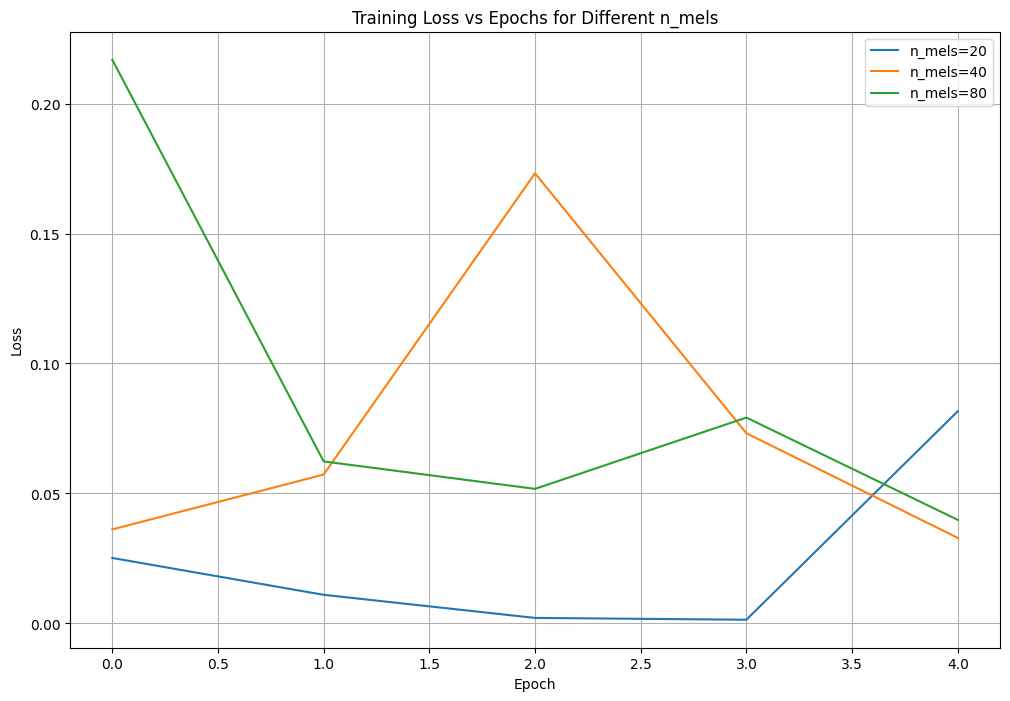

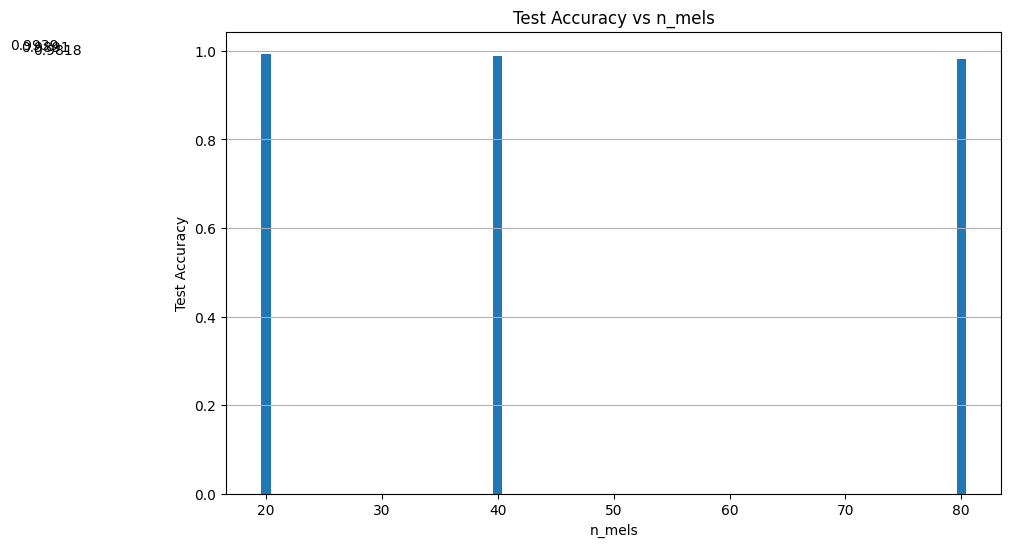

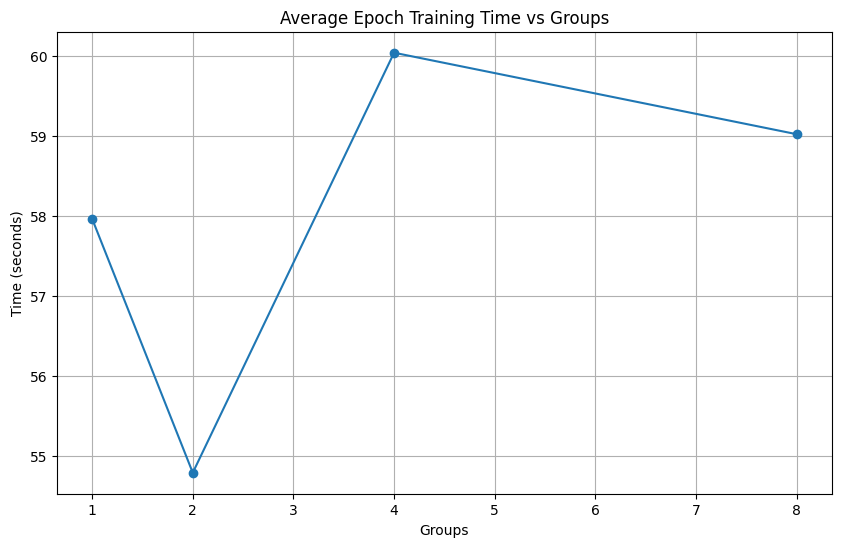

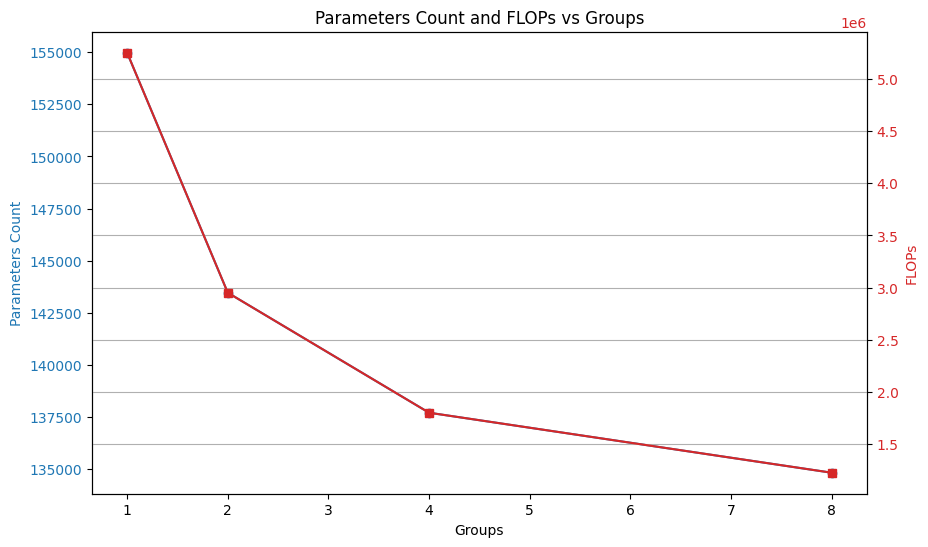

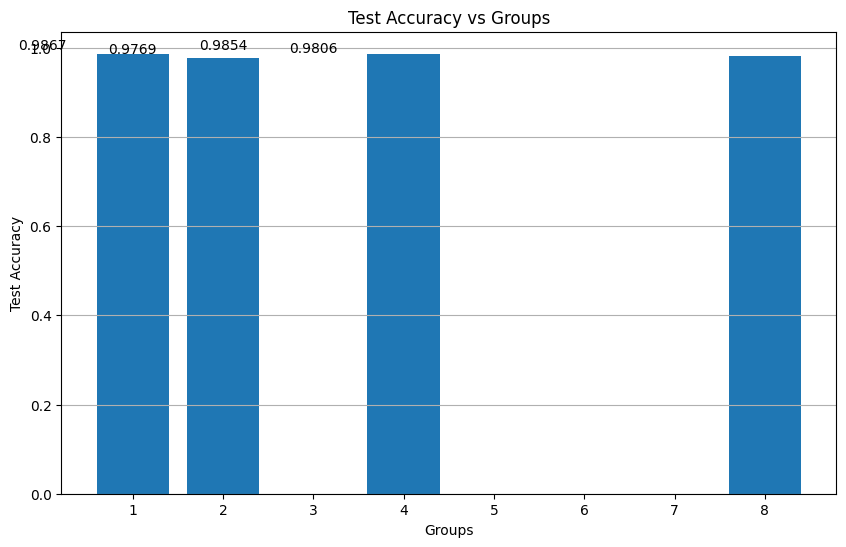


=== Сводная таблица результатов ===

Результаты экспериментов с n_mels:
  n_mels   |  Test Acc  |    Params    |      FLOPs      | Avg Epoch Time 
----------------------------------------------------------------------
    20     | 0.9939 | 154,978 | 5,253,888.0 | 56.93s
    40     | 0.9891 | 154,978 | 10,376,192.0 | 70.32s
    80     | 0.9818 | 154,978 | 20,620,032.0 | 99.67s

Результаты экспериментов с groups:
  groups   |  Test Acc  |    Params    |      FLOPs      | Avg Epoch Time 
----------------------------------------------------------------------
    1      | 0.9867 | 154,978 | 5,253,888.0 | 57.97s
    2      | 0.9769 | 143,458 | 2,949,888.0 | 54.79s
    4      | 0.9854 | 137,698 | 1,797,888.0 | 60.04s
    8      | 0.9806 | 134,818 | 1,221,888.0 | 59.02s


In [18]:
# Запуск всех экспериментов
# Установка seed для воспроизводимости
pl.seed_everything(42)

# Полные списки для экспериментов
n_mels_list = [20, 40, 80]
groups_list = [1, 2, 4, 8]
epochs = 5  # Увеличено до 5 эпох для лучшей сходимости
batch_size = 32

print("=== ПОЛНЫЙ ЭКСПЕРИМЕНТ ===")
print(f"n_mels: {n_mels_list}")
print(f"groups: {groups_list}")
print(f"epochs: {epochs}")
print(f"batch_size: {batch_size}")

# Запуск экспериментов с n_mels
print("\n=== Эксперименты с разными n_mels ===")
n_mels_results = run_n_mels_experiment(n_mels_list=n_mels_list, batch_size=batch_size, epochs=epochs)

# Определение лучшего n_mels
best_n_mels = max(n_mels_results.keys(), key=lambda n: n_mels_results[n]['test_accuracy'])
print(f"\nЛучшее значение n_mels: {best_n_mels} с точностью: {n_mels_results[best_n_mels]['test_accuracy']:.4f}")

# Запуск экспериментов с groups
print("\n=== Эксперименты с разными groups ===")
groups_results = run_groups_experiment(n_mels=best_n_mels, groups_list=groups_list, batch_size=batch_size, epochs=epochs)

# Визуализация результатов
print("\n=== Визуализация результатов ===")
plot_results(n_mels_results, groups_results)

# Вывод сводной таблицы результатов
print("\n=== Сводная таблица результатов ===")
print("\nРезультаты экспериментов с n_mels:")
print(f"{'n_mels':^10} | {'Test Acc':^10} | {'Params':^12} | {'FLOPs':^15} | {'Avg Epoch Time':^15}")
print("-" * 70)
for n_mels, data in n_mels_results.items():
    print(f"{n_mels:^10} | {data['test_accuracy']:.4f} | {data['params_count']:,} | {data['flops']:,} | {np.mean(data['epoch_times']):.2f}s")

print("\nРезультаты экспериментов с groups:")
print(f"{'groups':^10} | {'Test Acc':^10} | {'Params':^12} | {'FLOPs':^15} | {'Avg Epoch Time':^15}")
print("-" * 70)
for groups, data in groups_results.items():
    print(f"{groups:^10} | {data['test_accuracy']:.4f} | {data['params_count']:,} | {data['flops']:,} | {np.mean(data['epoch_times']):.2f}s")

# Experimental Results and Analysis

## Analysis of Experiments with Different Number of Mel-Filterbanks (n_mels)

1. **Classification Accuracy**: The highest accuracy (99.39%) was achieved with the lowest number of mel-filterbanks (n_mels=20). As n_mels increased, the accuracy slightly decreased: 98.91% for n_mels=40 and 98.18% for n_mels=80.

2. **Computational Complexity**: The number of FLOPs increased proportionally with n_mels: from 5.25M for n_mels=20 to 20.62M for n_mels=80 (approximately 4 times higher).

3. **Training Time**: The average epoch time also increased with n_mels: from 56.93s for n_mels=20 to 99.67s for n_mels=80 (almost doubled).

4. **Parameter Count**: Interestingly, the model parameter count remained constant (154,978) across different n_mels values. This is because changing n_mels only affects the input data dimensions, not the model architecture itself.

## Analysis of Experiments with Different Values of Groups Parameter

1. **Classification Accuracy**: The best accuracy (98.67%) was achieved with groups=1, followed by groups=4 (98.54%), groups=8 (98.06%), and groups=2 (97.69%). Note that the relationship is non-monotonic.

2. **Parameter Count**: As the groups parameter increased, the number of parameters decreased: from 154,978 with groups=1 to 134,818 with groups=8. This is expected as grouped convolutions use fewer parameters.

3. **Computational Efficiency**: FLOPs decreased significantly with increasing groups: from 5.25M with groups=1 to 1.22M with groups=8 (more than 4 times reduction).

4. **Training Time**: Interestingly, the average epoch time didn't show a clear dependency on the groups parameter, fluctuating between 54-60 seconds. This might be related to PyTorch's optimization or hardware specifics.

## Conclusions

1. **Optimal Parameters**: For this binary classification task ("yes"/"no"), the most effective configuration is n_mels=20 with groups=1, providing the highest accuracy (99.39%).

2. **Accuracy-Efficiency Trade-off**: If computational efficiency is critical, using n_mels=20 with groups=4 or groups=8 offers a 2.9-4.3x reduction in FLOPs with only a minor decrease in accuracy (0.85-1.33%).

3. **Overfitting**: Models with more parameters (lower groups) may suffer from overfitting, which explains the non-monotonic relationship between accuracy and groups.

4. **Feature Dimensionality**: Increasing n_mels doesn't lead to better accuracy, indicating that a small number of mel-filterbanks is sufficient for this task.

In summary, for the binary speech command classification task ("yes"/"no"), the optimal configuration uses a small number of mel-filterbanks (n_mels=20) and standard convolutions (groups=1), providing high accuracy with moderate computational costs. When resources are limited, using grouped convolutions can significantly reduce computational requirements with minimal impact on accuracy.